In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 20 20:01:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [33]:
import pandas as pd

In [34]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/MMA/new_data_FINAL.csv")

In [35]:
# converting 'Disch Datetime', 'Reg Datetime' and 'ORD Datetime' to datetime format
data['Reg Datetime'] = pd.to_datetime(data['Reg Datetime'])
data['ORD Datetime'] = pd.to_datetime(data['ORD Datetime'])

In [36]:
data['LOS_Current'] = data['ORD Datetime'] - data['Reg Datetime']

In [37]:
# Convert timedelta to number of days
data['LOS_Current'] = data['LOS_Current'].dt.total_seconds() / (24 * 60 * 60)

In [38]:
data['ORD Day'] = data['ORD Datetime'].dt.day
data['ORD Month'] = data['ORD Datetime'].dt.month

data['Reg Day'] = data['Reg Datetime'].dt.day
data['Reg Month'] = data['Reg Datetime'].dt.month

In [39]:
data.drop(columns=[ 'Disch_Disp', 'Disch Datetime', 'LOS_Computed', 'Bed','SERV_disch', 'ORD Datetime', 'Reg Datetime'], inplace=True)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4558 entries, 0 to 4557
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Adm_Unit          4558 non-null   object 
 1   SERV_adm          4558 non-null   object 
 2   Reason for Visit  4558 non-null   object 
 3   Age               4558 non-null   int64  
 4   Sex               4558 non-null   object 
 5   Disch_Unit        4558 non-null   object 
 6   ADM Type          4558 non-null   object 
 7   Disch Type        4558 non-null   object 
 8   Target            4558 non-null   int64  
 9   LOS_Current       4558 non-null   float64
 10  ORD Day           4558 non-null   int64  
 11  ORD Month         4558 non-null   int64  
 12  Reg Day           4558 non-null   int64  
 13  Reg Month         4558 non-null   int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 498.7+ KB


In [ ]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from tabulate import tabulate

# Assuming df_info is the DataFrame you want to print
#print(tabulate(data, headers='keys', tablefmt='psql', showindex=False))

In [ ]:
pip install scikit-learn==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'Reason for Visit' column
tfidf_matrix = vectorizer.fit_transform(data['Reason for Visit'])

# Create a new DataFrame with the TF-IDF data
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the original DataFrame (without the 'Reason for Visit' column) and the new DataFrame
data = pd.concat([data.drop('Reason for Visit', axis=1), tfidf_df], axis=1)

# stop

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Step 2: Preprocess the data
# Convert categorical variables into numerical variables using label encoding
encoder = LabelEncoder()
categorical_cols = ['Adm_Unit', 'SERV_adm', 'Sex', 'Disch_Unit', 'ADM Type', 'Disch Type']
data[categorical_cols] = data[categorical_cols].apply(encoder.fit_transform)

# Drop columns if necessary
# Let's keep all columns for now as they seem relevant. If the performance is not satisfactory, we can revisit this.

# Step 3: Split the data into training and testing sets
X = data.drop('Target', axis=1)  # Input variables (features)
y = data['Target']  # Output variable (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 5: Predict and evaluate on the training set
y_train_pred = clf.predict(X_train)
print("Training Set Evaluation:")
print(classification_report(y_train, y_train_pred))
print(f"Accuracy: {accuracy_score(y_train, y_train_pred)*100}%")
print(f"AUC-ROC: {roc_auc_score(y_train, y_train_pred)*100}%")

# Step 6: Predict and evaluate on the testing set
y_test_pred = clf.predict(X_test)
print("\nTesting Set Evaluation:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)*100}%")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_pred)*100}%")

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00      3445

    accuracy                           1.00      3646
   macro avg       1.00      1.00      1.00      3646
weighted avg       1.00      1.00      1.00      3646

Accuracy: 100.0%
AUC-ROC: 100.0%

Testing Set Evaluation:
              precision    recall  f1-score   support

           0       0.12      0.15      0.13        47
           1       0.95      0.94      0.95       865

    accuracy                           0.90       912
   macro avg       0.54      0.55      0.54       912
weighted avg       0.91      0.90      0.91       912

Accuracy: 90.13157894736842%
AUC-ROC: 54.55663510023368%


# Random Forest

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'Reason for Visit' column
tfidf_matrix = vectorizer.fit_transform(data['Reason for Visit'])

# Create a new DataFrame with the TF-IDF data
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

# Concatenate the original DataFrame (without the 'Reason for Visit' column) and the new DataFrame
data = pd.concat([data.drop('Reason for Visit', axis=1), tfidf_df], axis=1)


2023-06-14 21:02:22,191 [14140] WARNING  py.warnings:109: [JupyterRequire] C:\Users\A1_MED_NB01\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Step 2: Preprocess the data
encoder = LabelEncoder()
categorical_cols = ['Adm_Unit', 'SERV_adm', 'Sex', 'Disch_Unit', 'ADM Type', 'Disch Type']
data[categorical_cols] = data[categorical_cols].apply(encoder.fit_transform)

# Step 3: Split the data
X = data.drop('Target', axis=1)
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform SMOTE resampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# If the k_neighbors parameter is not explicitly specified in the SMOTE function, it defaults to 5.
# This means that for each instance of the minority class, 5 nearest neighbors are considered.

# Step 4: Train the random forest
# Use a smaller number of features for each tree
clf = RandomForestClassifier(max_features=5, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Predict and evaluate on the training set
y_train_pred = clf.predict(X_train)
print("Training Set Evaluation:")
print(classification_report(y_train, y_train_pred))
print(f"Accuracy: {accuracy_score(y_train, y_train_pred)*100}%")
print(f"AUC-ROC: {roc_auc_score(y_train, y_train_pred)*100}%")

# Step 6: Predict and evaluate on the testing set
y_test_pred = clf.predict(X_test)
print("\nTesting Set Evaluation:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)*100}%")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_pred)*100}%")


Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00      3445

    accuracy                           1.00      3646
   macro avg       1.00      1.00      1.00      3646
weighted avg       1.00      1.00      1.00      3646

Accuracy: 99.97257268239166%
AUC-ROC: 99.75124378109453%

Testing Set Evaluation:
              precision    recall  f1-score   support

           0       0.36      0.09      0.14        47
           1       0.95      0.99      0.97       865

    accuracy                           0.95       912
   macro avg       0.66      0.54      0.55       912
weighted avg       0.92      0.95      0.93       912

Accuracy: 94.51754385964912%
AUC-ROC: 53.85069487147952%


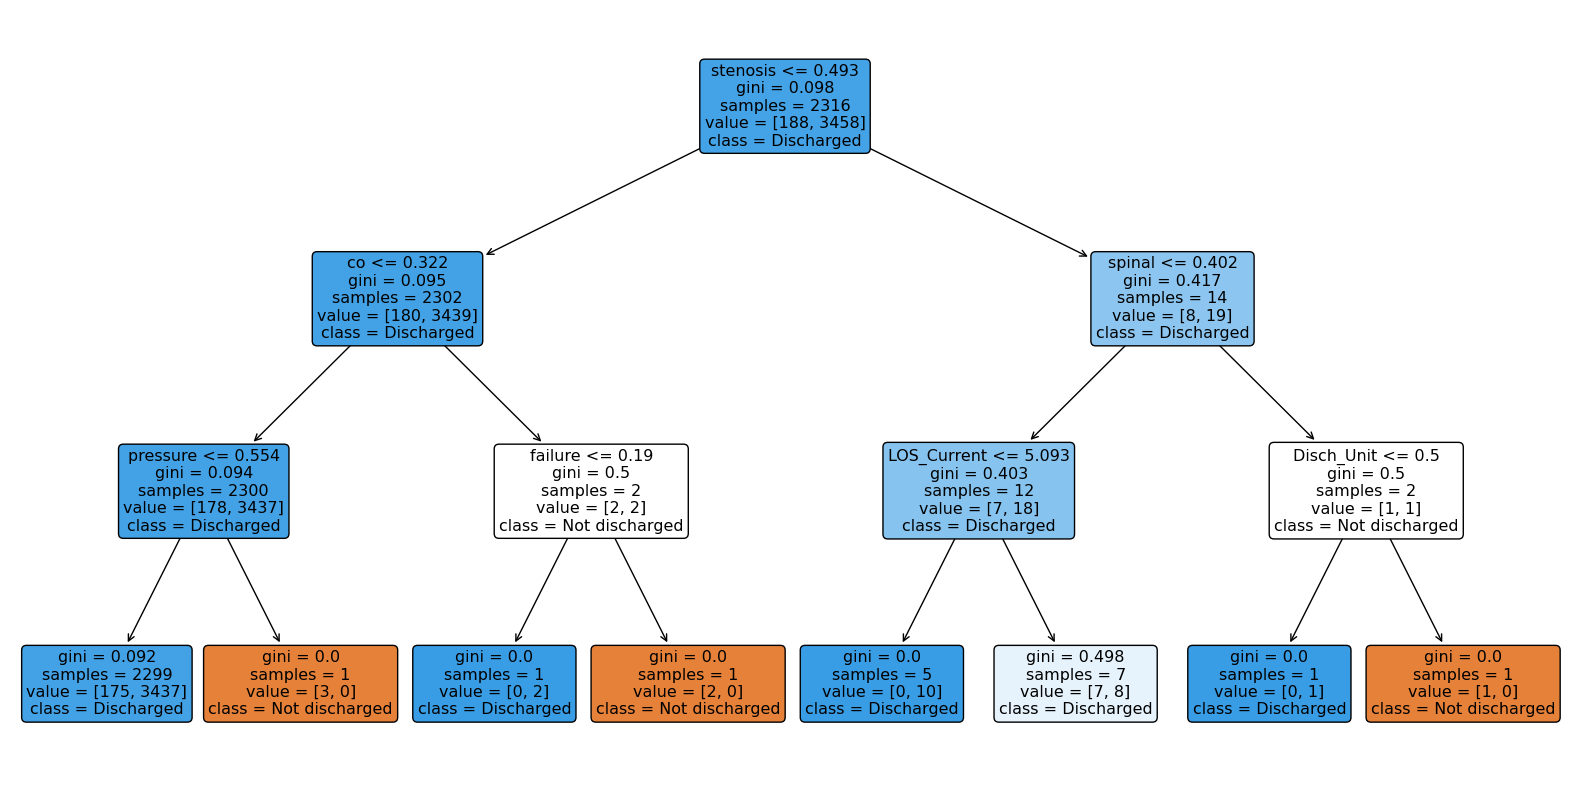

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# train the Random Forest classifier and get one of the trees
clf = RandomForestClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
one_tree = clf.estimators_[0]  # Get the first tree

# set the size of the figure
plt.figure(figsize=(20,10))

# plot the tree
plot_tree(one_tree,
          filled=True,
          rounded=True,
          class_names=['Not discharged', 'Discharged'],
          feature_names=X.columns)

# show the plot
plt.show()


In [ ]:
# Train the Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame to display the feature importances
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by the importance score
features.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
print(features)


                    Feature  Importance
7               LOS_Current    0.113488
8                   ORD Day    0.104777
2                       Age    0.067159
10                  Reg Day    0.059554
9                 ORD Month    0.046910
...                     ...         ...
1110                ostitis    0.000000
1109                osteosa    0.000000
1108  osteomyelitisdiscitis    0.000000
1099                orbital    0.000000
1614                   yuri    0.000000

[1615 rows x 2 columns]


In [ ]:
# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame to display the feature importances
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by the importance score
features.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
print(features)

              Feature  Importance
7         LOS_Current    0.120444
8             ORD Day    0.113427
2                 Age    0.073791
10            Reg Day    0.065735
9           ORD Month    0.051715
...               ...         ...
1452             thou    0.000000
769            herpes    0.000000
402         delusions    0.000000
408   dementiafalletc    0.000000
128        asthmapalm    0.000000

[1615 rows x 2 columns]


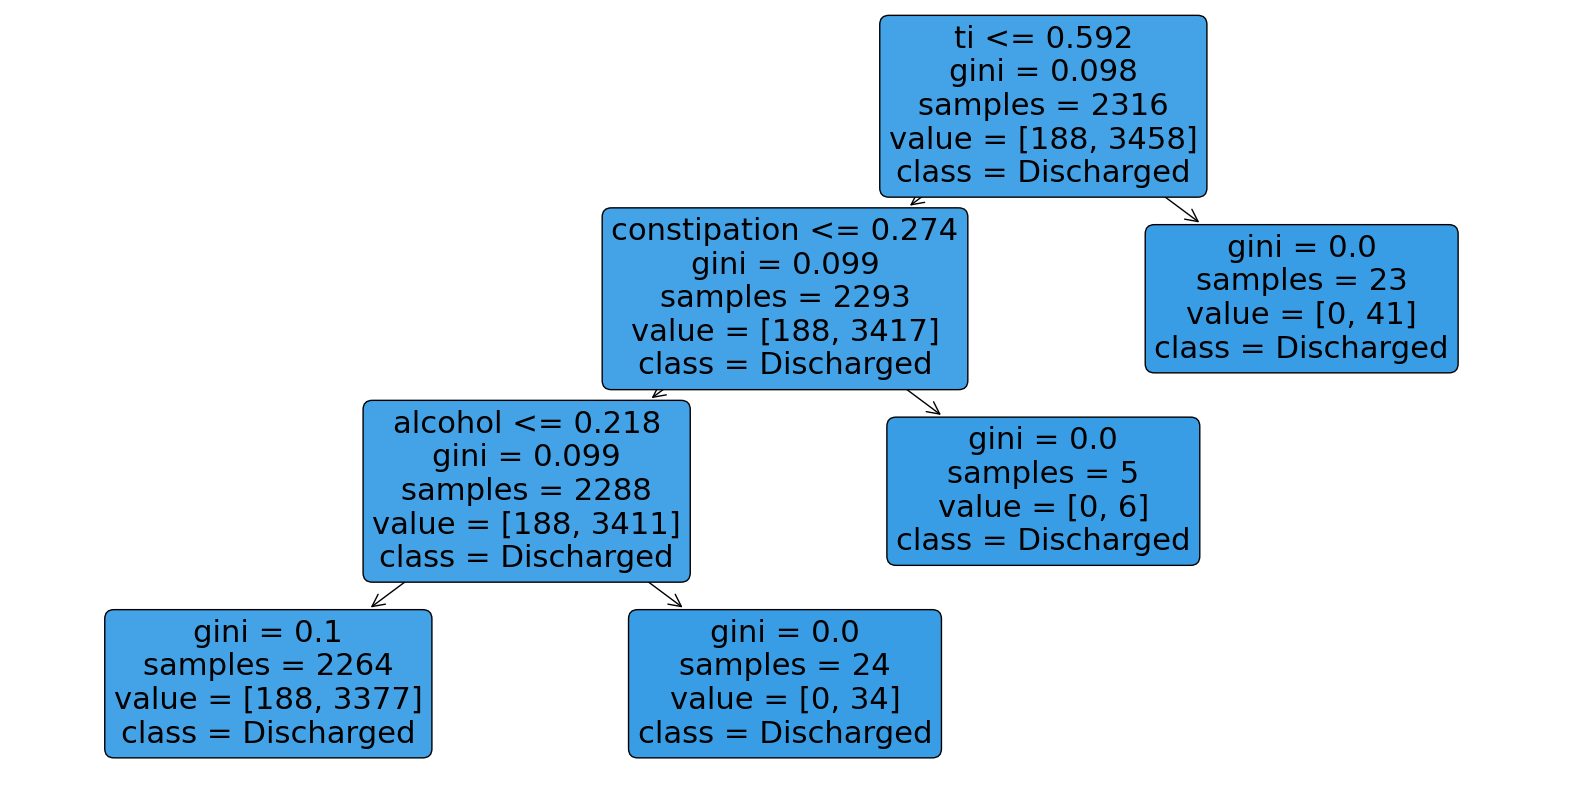

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# train the Random Forest classifier and get one of the trees
clf = RandomForestClassifier(max_depth = 3,max_features=3, random_state=42)
clf.fit(X_train, y_train)
one_tree = clf.estimators_[0]  # Get the first tree

# set the size of the figure
plt.figure(figsize=(20,10))

# plot the tree
plot_tree(one_tree,
          filled=True,
          rounded=True,
          class_names=['Not discharged', 'Discharged'],
          feature_names=X.columns)

# show the plot
plt.show()

# XGBoost &  SMOTE resampling

In [ ]:
!pip install -U imbalanced-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 2: Preprocess the data
# Convert categorical variables into numerical variables using label encoding
# Define categorical columns
categorical_cols = ['Adm_Unit', 'SERV_adm', 'Sex', 'Disch_Unit', 'ADM Type', 'Disch Type']

# Create a dictionary to store the label encoders for each column
encoders = {}

# Convert categorical variables into numerical variables using label encoding
for col in categorical_cols:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    encoders[col] = encoder  # store the encoder

X = data.drop('Target', axis=1)  # Input variables (features)
y = data['Target']  # Output variable (target)

# Split original data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform SMOTE resampling on the training set only

#sm = SMOTE(random_state=42)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.1) # indicating the 100:1 ratio
X_train_res, y_train_res = undersample.fit_resample(X_train, y_train)


In [45]:
# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    random_state=42,
                    max_depth=4,        # prevent the model from becoming too complex
                    reg_lambda=5,       # L2 regularization term on weights
                    reg_alpha=1)        # L1 regularization term on weights

# Fit the model
xgb_model.fit(X_train_res, y_train_res)

# Make predictions on the training set
train_preds = xgb_model.predict(X_train_res)
train_probs = xgb_model.predict_proba(X_train_res)[:,1]

# Make predictions on the test set
test_preds = xgb_model.predict(X_test)
test_probs = xgb_model.predict_proba(X_test)[:,1]

# Evaluate the model
print("\nTraining Set Evaluation:")
print(classification_report(y_train_res, train_preds))
print("Training Accuracy: ", accuracy_score(y_train_res, train_preds))
print("Training AUC-ROC: ", roc_auc_score(y_train_res, train_probs))

print("\nTesting Set Evaluation:")
print(classification_report(y_test, test_preds))
print("Testing Accuracy: ", accuracy_score(y_test, test_preds))
print("Testing AUC-ROC: ", roc_auc_score(y_test, test_probs))



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.23      0.37       201
           1       0.93      1.00      0.96      2010

    accuracy                           0.93      2211
   macro avg       0.95      0.61      0.67      2211
weighted avg       0.93      0.93      0.91      2211

Training Accuracy:  0.9294436906377205
Training AUC-ROC:  0.9560543055864954

Testing Set Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.95      0.99      0.97       865

    accuracy                           0.94       912
   macro avg       0.47      0.50      0.49       912
weighted avg       0.90      0.94      0.92       912

Testing Accuracy:  0.9418859649122807
Testing AUC-ROC:  0.6898782437584553


In [25]:
# Fit the model
xgb_model.fit(X_train_res, y_train_res)

# Make predictions on the training set
train_preds = xgb_model.predict(X_train_res)
train_probs = xgb_model.predict_proba(X_train_res)[:,1]

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'colsample_bylevel': [0.4, 0.5, 0.6],
    'min_child_weight': [0.5, 1.0, 3.0],
    'gamma': [0, 0.25, 0.5],
    'reg_lambda': [0.1, 1.0, 5.0],
    'n_estimators': [10],
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', verbose=3, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_parameters = grid_search.best_params_
print("Best Parameters: ", best_parameters)

# Get the best score
best_score = grid_search.best_score_
print("Best Score: ", best_score)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Make predictions using the best estimator
train_preds = best_estimator.predict(X_train_res)
train_probs = best_estimator.predict_proba(X_train_res)[:,1]

# Make predictions on the test set
test_preds = best_estimator.predict(X_test)
test_probs = best_estimator.predict_proba(X_test)[:,1]

# Evaluate the model
print("\nTraining Set Evaluation:")
print(classification_report(y_train_res, train_preds))
print("Training Accuracy: ", accuracy_score(y_train_res, train_preds))
print("Training AUC-ROC: ", roc_auc_score(y_train_res, train_probs))

print("\nTesting Set Evaluation:")
print(classification_report(y_test, test_preds))
print("Testing Accuracy: ", accuracy_score(y_test, test_preds))
print("Testing AUC-ROC: ", roc_auc_score(y_test, test_probs))


KeyboardInterrupt: ignored

# Lift Analysis

Testing Lift at top 1%:  1.0543352601156069

The lift score you have reported suggests that your model is 1.054 times more effective than a random model at identifying positive instances in the top 1% of its predictions. This is a relatively good score, indicating that the model is performing better than random guessing, at least in the top 1% of its predictions.

In the context of class imbalance, the lift score is a valuable metric because it can highlight the performance of a model where it's most confident, which is particularly useful when the positive class is rare.

However, keep in mind that a lift score at top 1% focuses only on a very small subset of the model's predictions. Therefore, it might be beneficial to consider other metrics as well when evaluating the overall performance of your model. These can include precision, recall, F1 score, and AUC-ROC, among others, which provide a more comprehensive view of your model's performance across all predictions, not just the top 1%.

## This is why Dimtry wanted us to swap 1s with 0s in the target variable. Delayed discharge = 1, 0 otherwise.

The calc_lift function as you've written it is not specifically looking at the minority or majority class. What it does is to calculate the "lift" of the model's predictions.

"Lift" is a measure of the effectiveness of a predictive model calculated as the ratio between the results obtained with and without the predictive model.

In the context of your function, "lift" is calculated as follows:

    Sort all instances by the predicted probabilities of the positive class in descending order.
    Cut off the top 1% (or whatever percentile you pass in).
    The "lift" is then the ratio of the true positive rate within this top 1% to the true positive rate in the entire dataset.

The idea is to check whether the model is particularly good at ranking the true positive instances highly. The higher the lift, the better your model is at ranking the positive instances at the top of the list.

It does not directly tell you whether the analysis is for the minority or majority class, but typically in an imbalanced classification problem, the positive class (which lift is often calculated for) is the minority class. Therefore, in an imbalanced classification context, this function is commonly used to evaluate the model's ability to detect instances of the minority class.

In [26]:
def calc_lift(y_true, y_probs, percentile=0.01):
    # Create a DataFrame of true labels and their predicted probabilities
    df = pd.DataFrame({'true': y_true, 'probs': y_probs})

    # Sort by predicted probabilities in descending order
    df = df.sort_values(by='probs', ascending=False)

    # Calculate the number of top-percentile cases
    top_percentile_cases = int(len(df) * percentile)

    # Calculate the lift as the ratio of true positives in the top percentile to the
    # expected number of true positives based on the overall prevalence
    lift = df['true'].iloc[:top_percentile_cases].mean() / df['true'].mean()

    return lift

# Calculate lift on the test set
lift_test = calc_lift(y_test, test_probs)
print("Testing Lift at top 1%: ", lift_test)

Testing Lift at top 1%:  1.0543352601156069


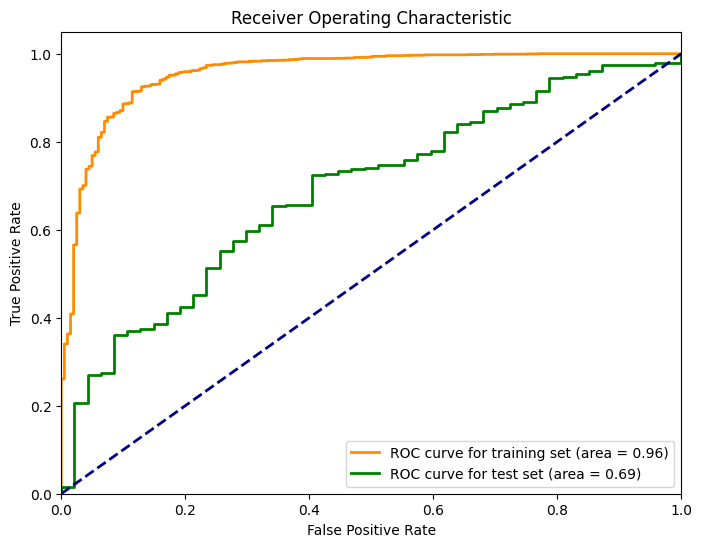

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr_train, tpr_train, _ = roc_curve(y_train_res, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
lw = 2

# Plotting ROC curve for the train set
plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='ROC curve for training set (area = %0.2f)' % roc_auc_train)

# Plotting ROC curve for the test set
plt.plot(fpr_test, tpr_test, color='green', lw=lw, label='ROC curve for test set (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [28]:
!pip install auto-sklearn

from autosklearn.classification import AutoSklearnClassifier

# Initialize the AutoSklearnClassifier
automl = AutoSklearnClassifier(time_left_for_this_task=120, per_run_time_limit=30)

# Fit the model
automl.fit(X_train, y_train)

# Print the final ensemble constructed by auto-sklearn.
print(automl.show_models())

# Get predictions
predictions = automl.predict(X_test)

# Evaluate the model
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 59.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 102.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.2 MB/s eta 0:00:00
  Created wheel for auto-sklea

FileNotFoundError: ignored

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

# Calculate the probability scores of each point in the training set
y_train_score = xgb_model.predict_proba(X_train_res)[:, 1]

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_res, y_train_score)

# Calculate the difference between the TPR and FPR for each threshold
J = train_tpr - train_fpr

# Find the optimal threshold
optimal_threshold = train_thresholds[np.argmax(J)]
print(optimal_threshold)


0.53954697


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, train_preds)
print("Training Set Confusion Matrix:\n", cm_train)

# Generate confusion matrix for the test set
cm_test = confusion_matrix(y_test_res, test_preds)
print("\nTesting Set Confusion Matrix:\n", cm_test)


Training Set Confusion Matrix:
 [[3174  289]
 [ 123 3310]]

Testing Set Confusion Matrix:
 [[774  73]
 [ 53 824]]


In [ ]:
# get feature importances
feature_importances = xgb_model.get_booster().get_score(importance_type='weight')

# sort feature importances in descending order and get top 10
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:10]

# print top 10 feature importances
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: LOS_Current, Importance: 34.0
Feature: ORD Day, Importance: 29.0
Feature: Age, Importance: 21.0
Feature: Reg Day, Importance: 18.0
Feature: pneumonia, Importance: 17.0
Feature: ORD Month, Importance: 16.0
Feature: cold, Importance: 15.0
Feature: SERV_adm, Importance: 13.0
Feature: falls, Importance: 12.0
Feature: Disch_Unit, Importance: 10.0


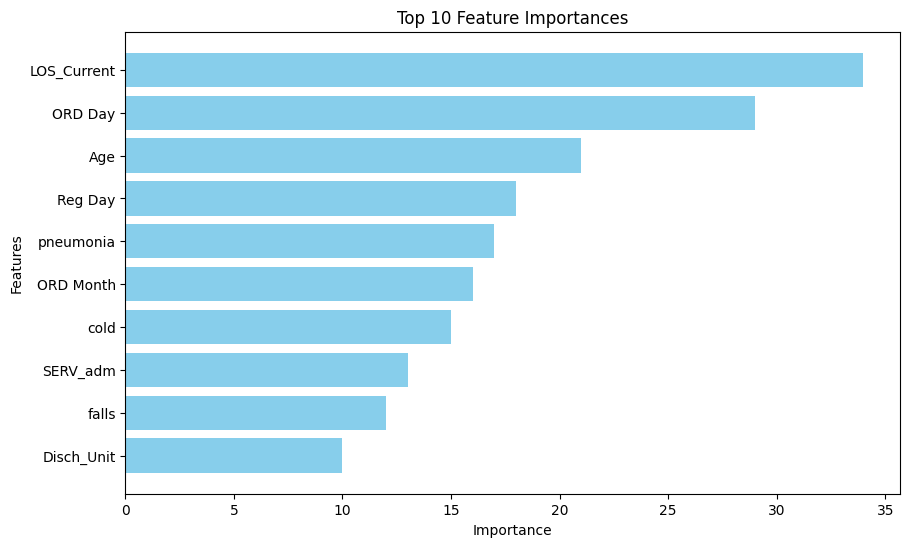

In [ ]:
import matplotlib.pyplot as plt

# get feature importances
feature_importances = xgb_model.get_booster().get_score(importance_type='weight')

# sort feature importances in descending order and get top 10
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:10]

# separate feature names and their importances
features, importances = zip(*sorted_feature_importances)

# create bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()  # reverse the order of features
plt.show()


## Synthetic Minority Over-sampling Technique (SMOTE)

In [ ]:
# how many features were created after SMOTE?
# print the number of samples before and after resampling
print(f"Number of samples before SMOTE: {len(y)}")
print(f"Number of samples after SMOTE: {len(y_res)}")

# how many new samples were created in total:
print(f"Number of new samples created: {len(y_res) - len(y)}")

Number of samples before SMOTE: 4558
Number of samples after SMOTE: 8620
Number of new samples created: 4062


In [ ]:
# Assuming `model` is your trained XGBoost model
print(xgb.get_booster().get_dump()[0])


NameError: name 'xgb' is not defined

In [ ]:
!pip install graphviz

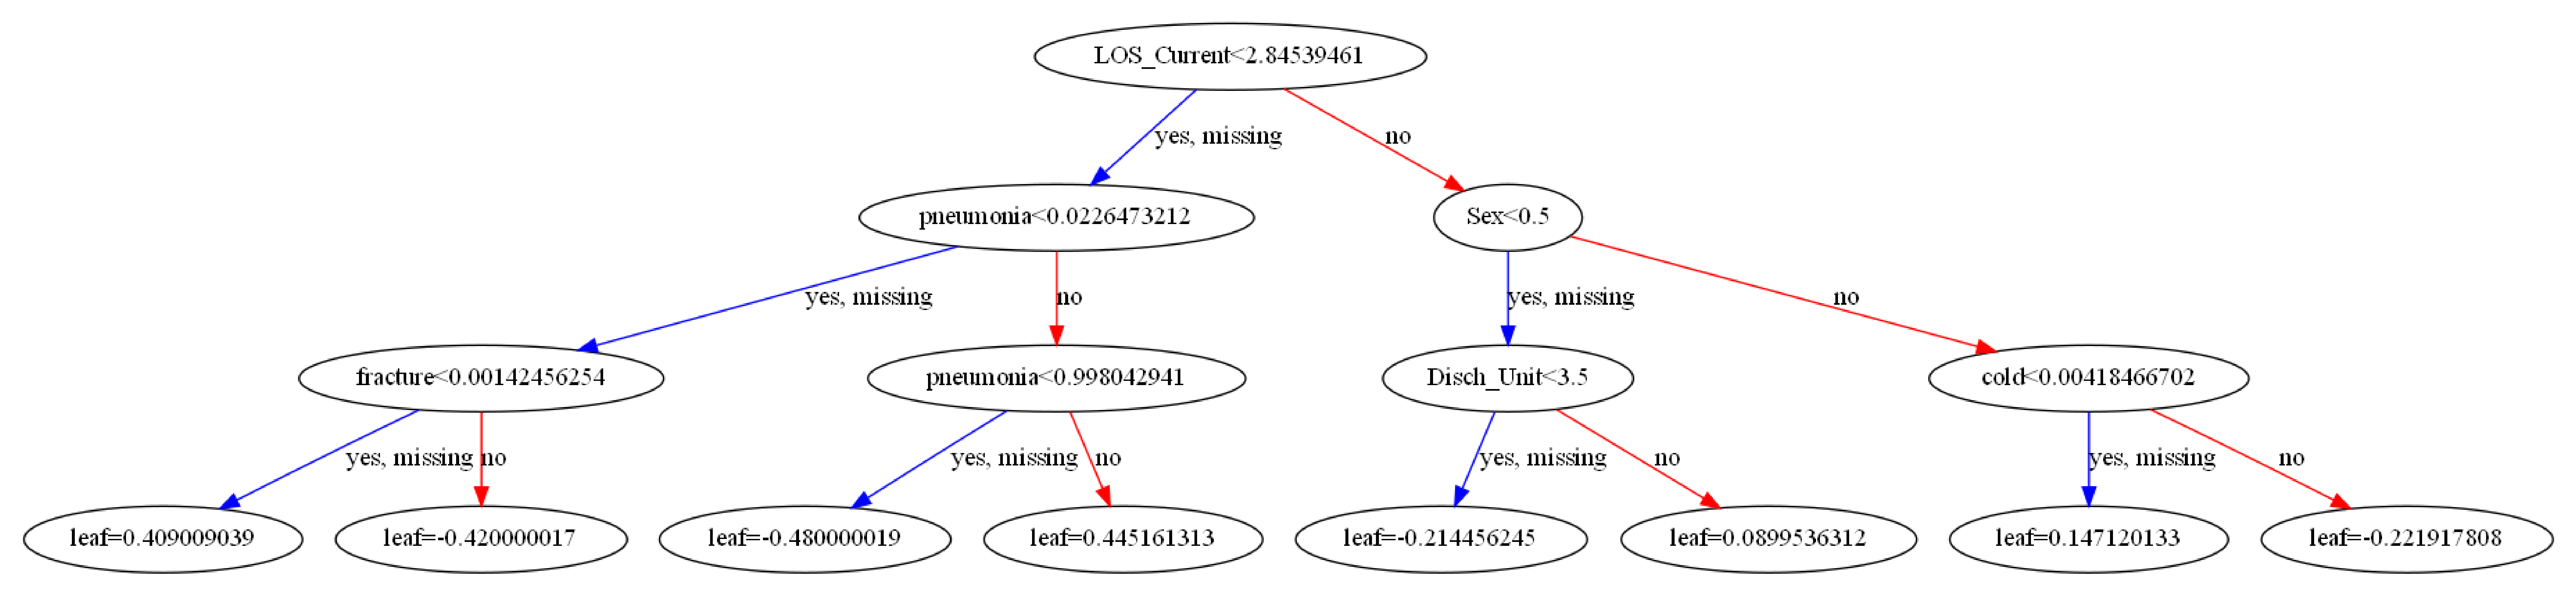

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20), dpi=500)
xgb.plot_tree(xgb_model, num_trees=0, ax=ax)
fig.savefig('tree_high_res.png')


## Post Modelling EDA

In [ ]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.0/570.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 3.5.4
    Uninstalling Sphinx-3.

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.6 MB/s eta 0:00:00


In [ ]:
# Correlations

# Get the top features from the sorted feature importances
top_features = [feature for feature, _ in sorted_feature_importances]


for feature in top_features:
    correlation = X_test_res[feature].corr(y)
    print(f"Correlation of {feature} with target: {correlation}")

Correlation of LOS_Current with target: -0.04361406585279532
Correlation of ORD Day with target: -0.05496280144057985
Correlation of Age with target: -0.0318943276716035
Correlation of Reg Day with target: 0.03657160568039232
Correlation of pneumonia with target: -0.03536659470332843
Correlation of ORD Month with target: -0.004380142879963208
Correlation of cold with target: -0.0472684934751439
Correlation of SERV_adm with target: -0.06208239481739586
Correlation of falls with target: -0.030357770847981826
Correlation of Disch_Unit with target: 0.04097657065516452


In [ ]:
!pip install pdpbox

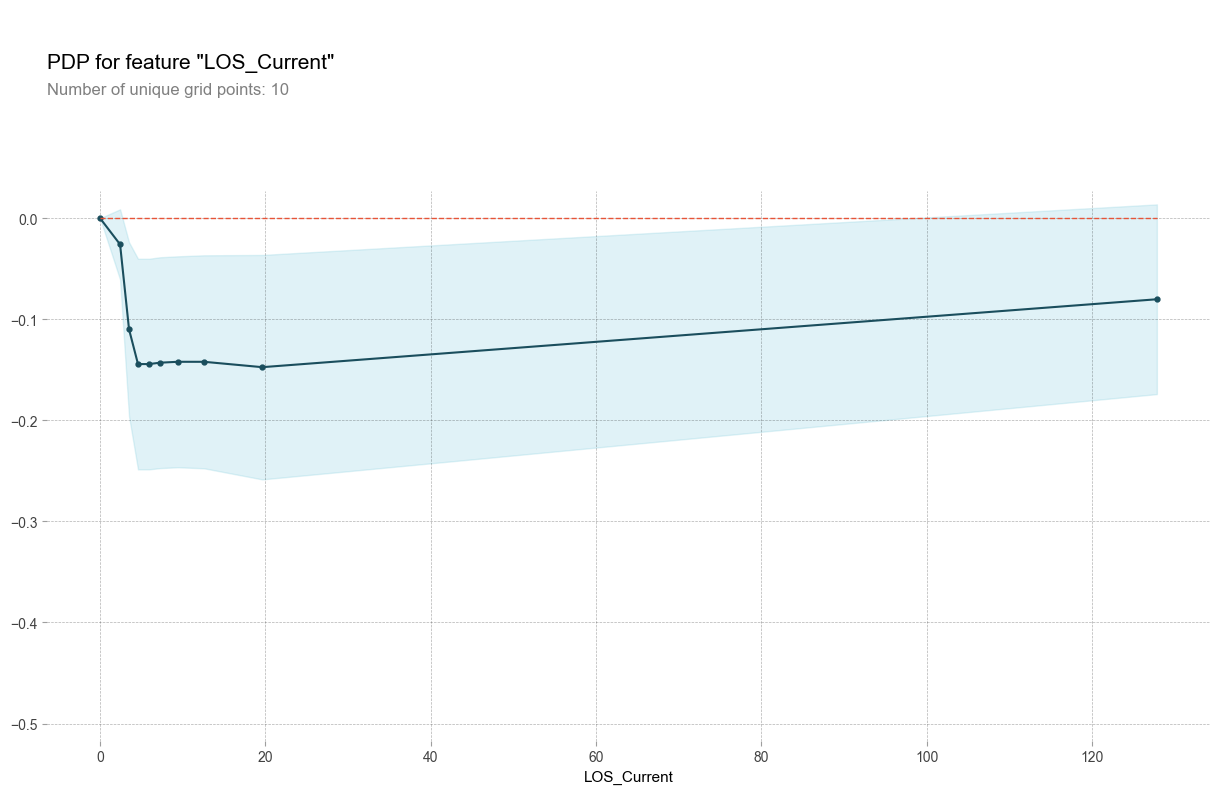

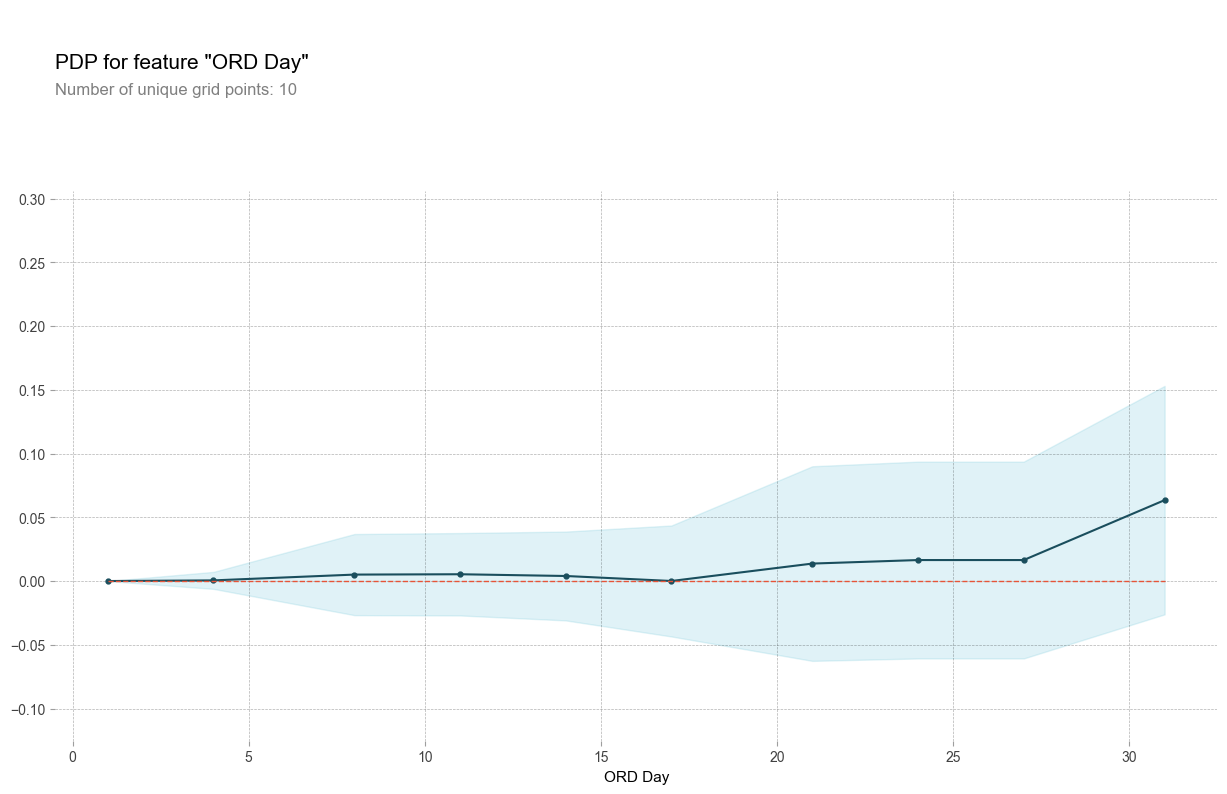

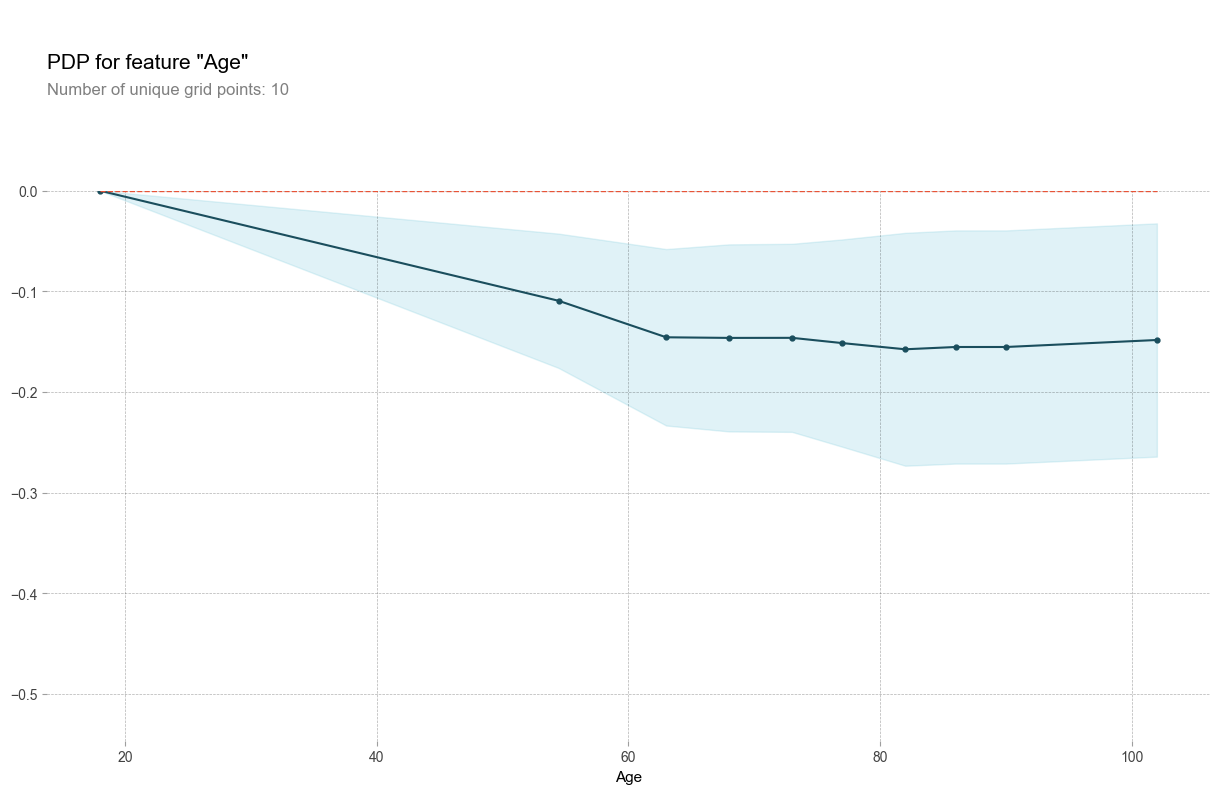

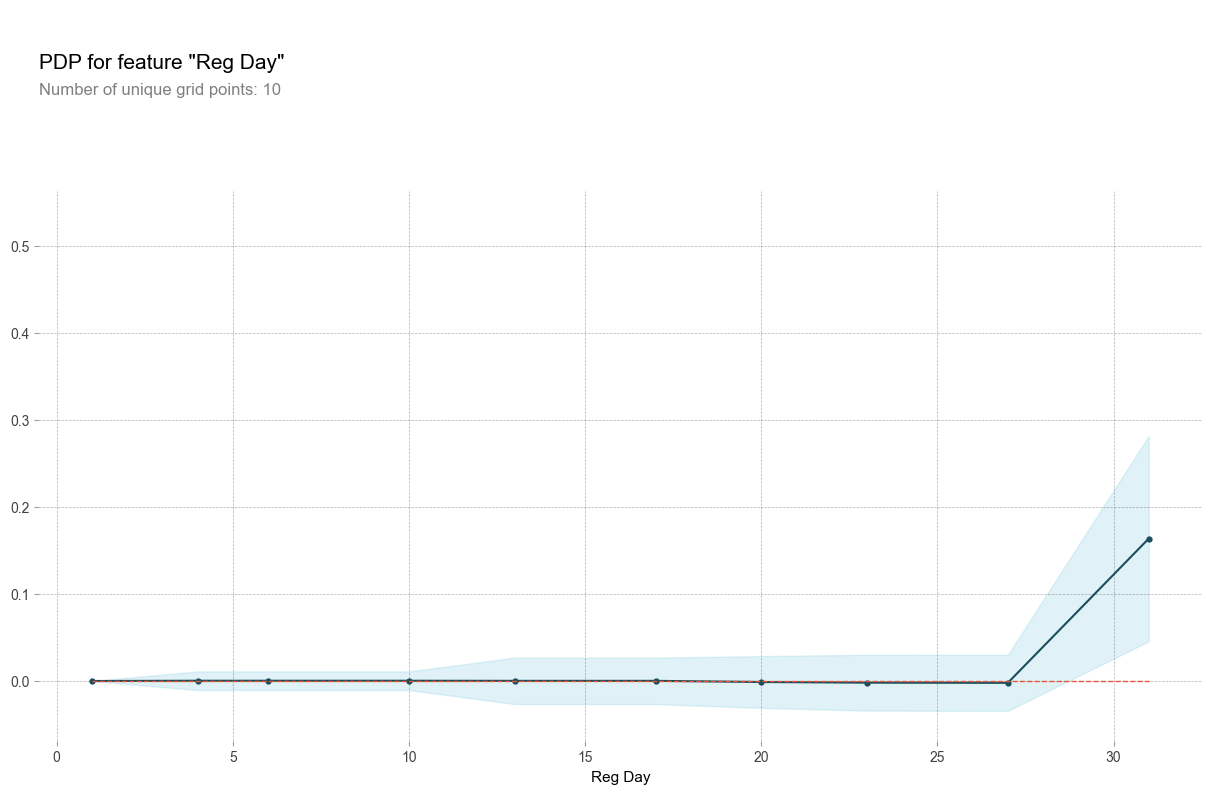

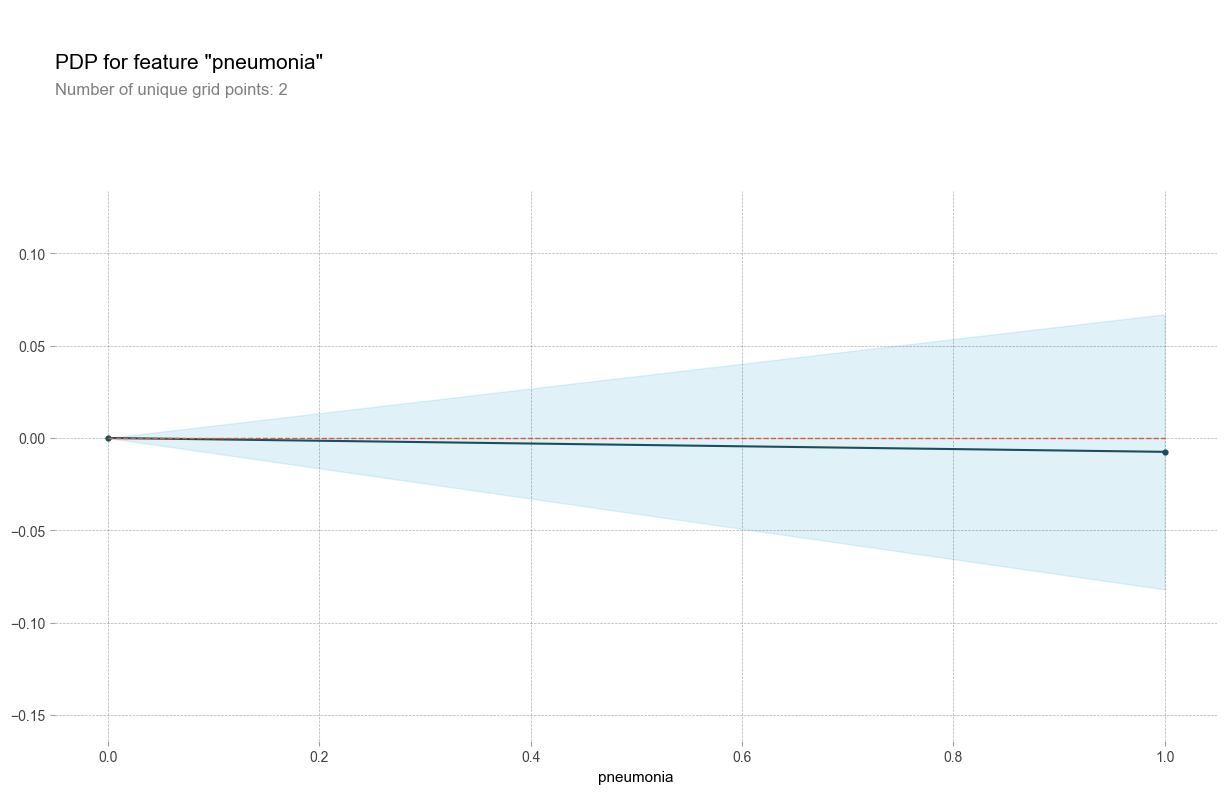

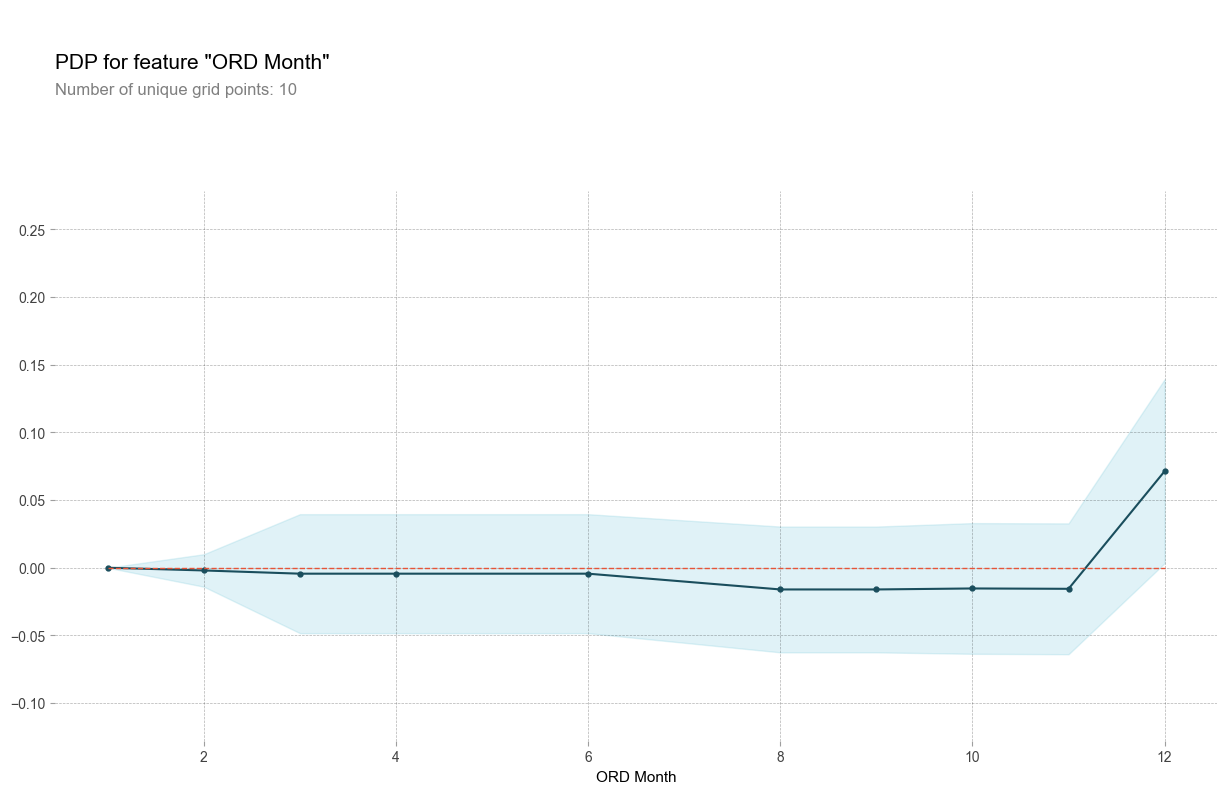

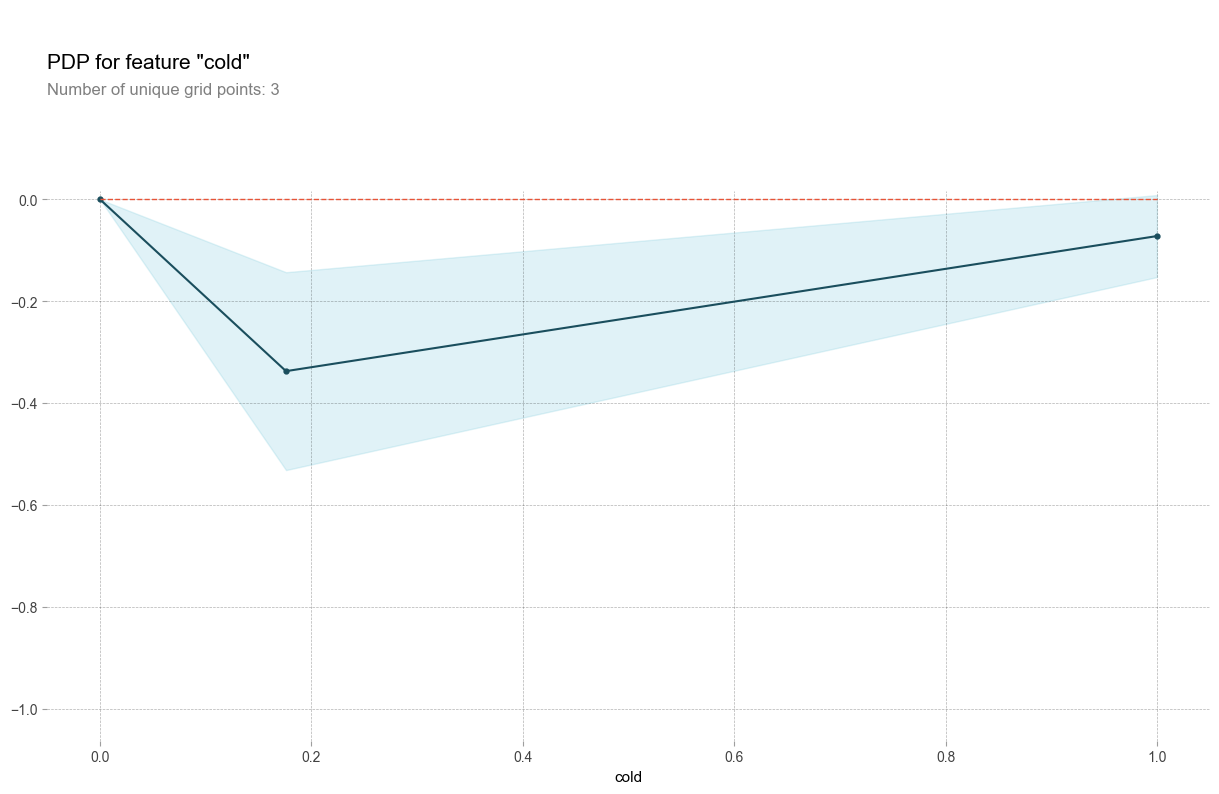

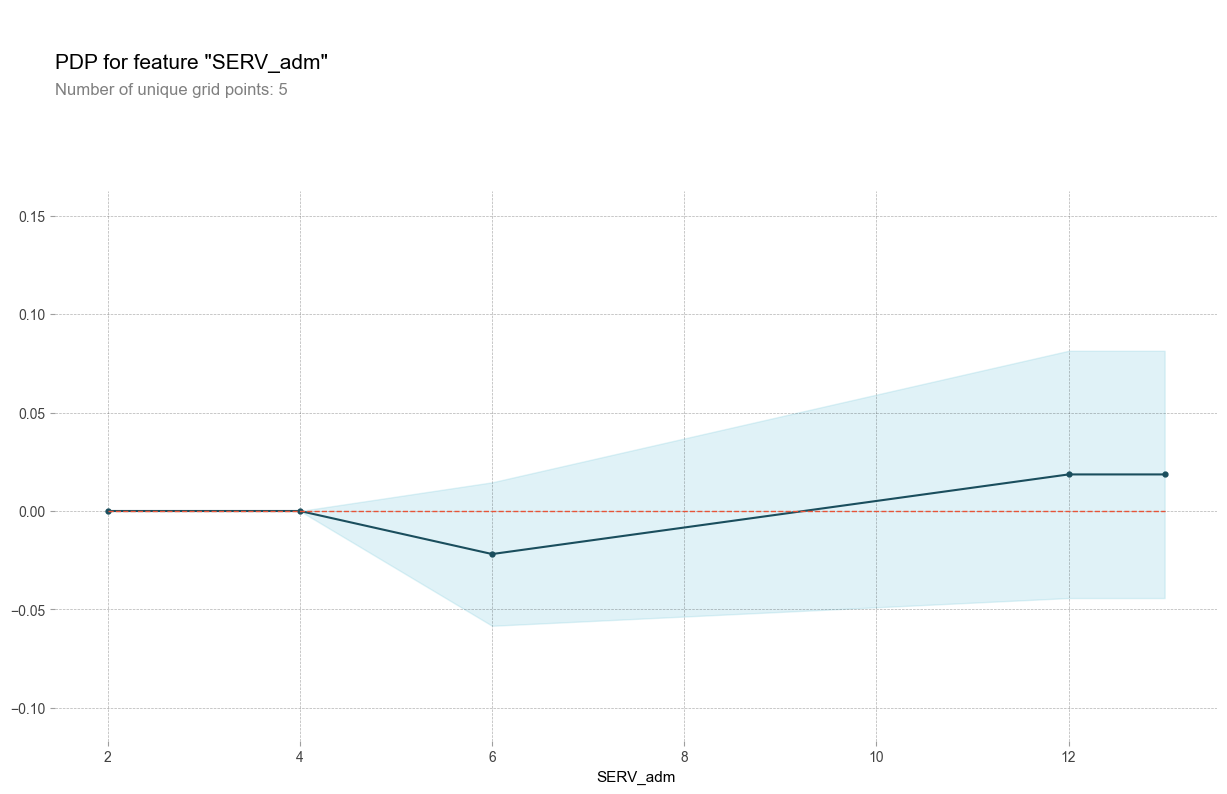

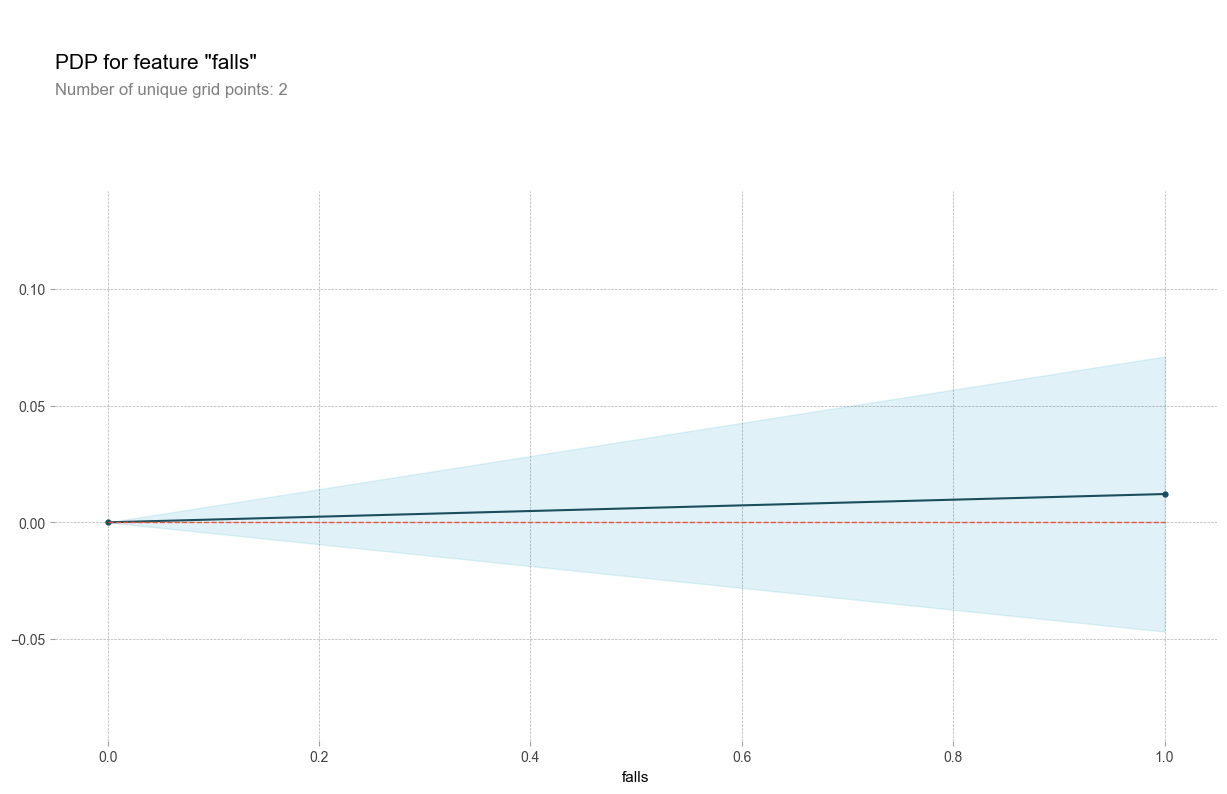

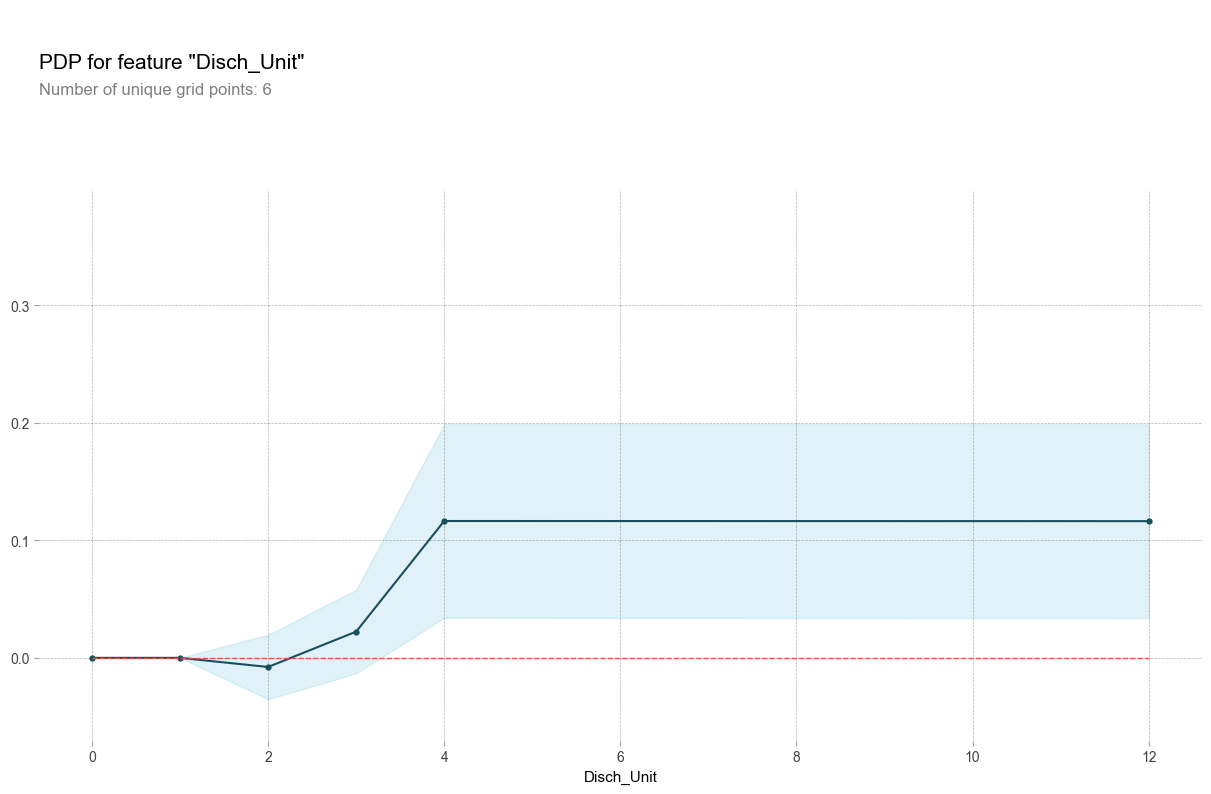

In [ ]:
# Partial Dependence Plots
from pdpbox import pdp
for feature in top_features:
    pdp_goals = pdp.pdp_isolate(model=xgb_model, dataset=X_test_res, model_features=X_test_res.columns, feature=feature)
    pdp.pdp_plot(pdp_goals, feature)
    plt.show()


# After decoding categorical variables

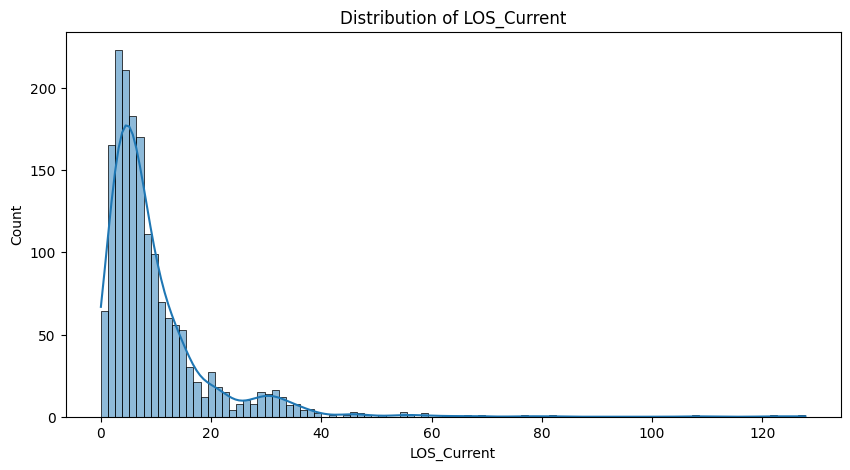

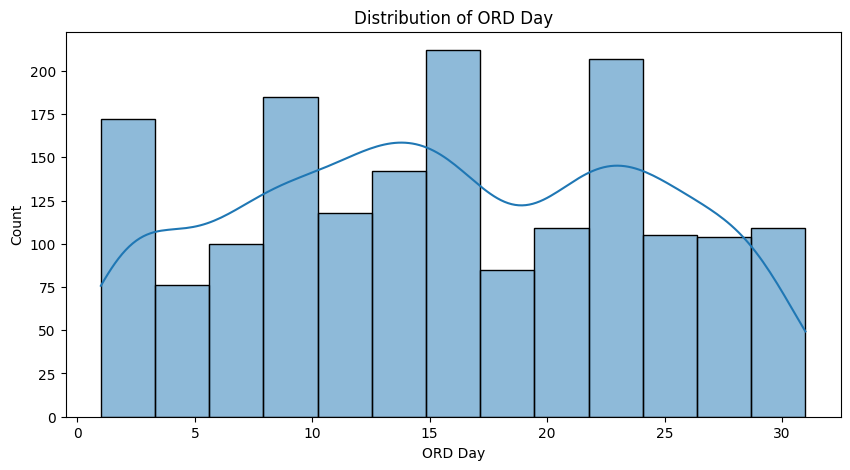

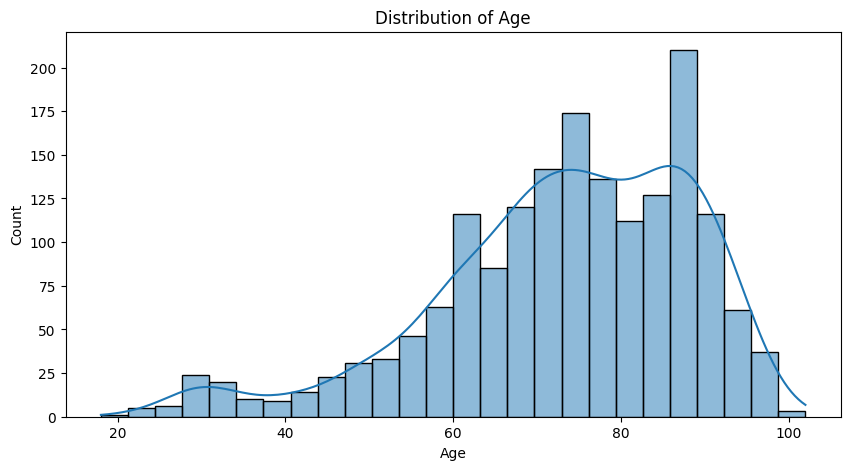

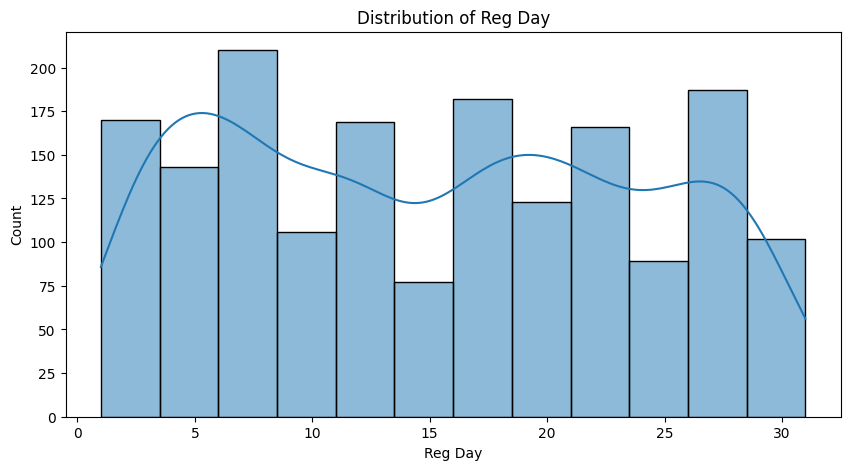

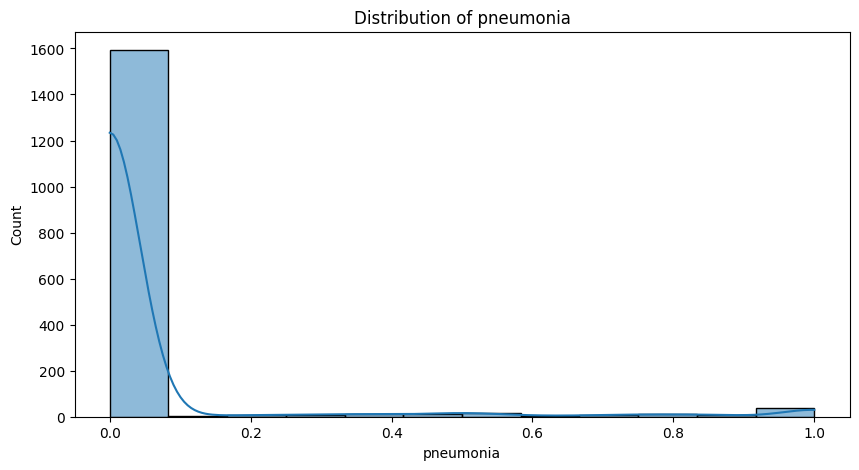

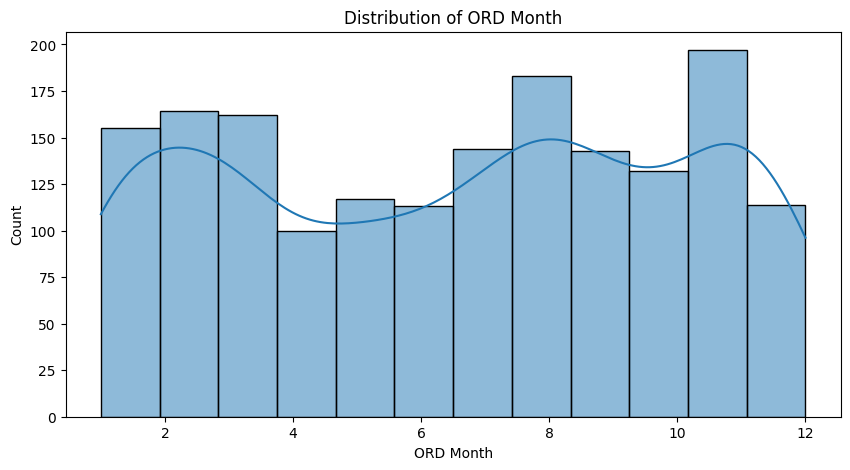

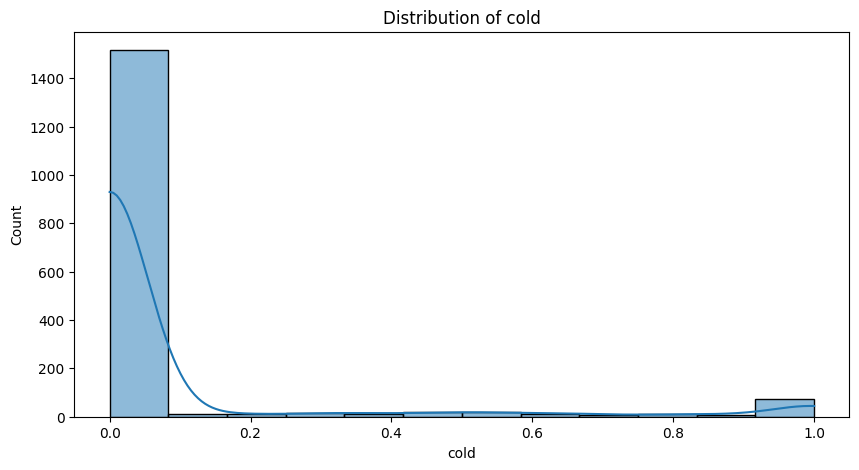

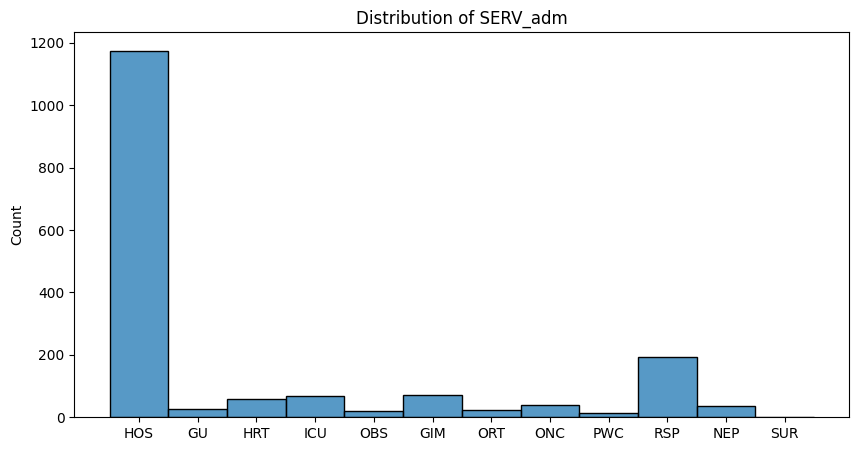

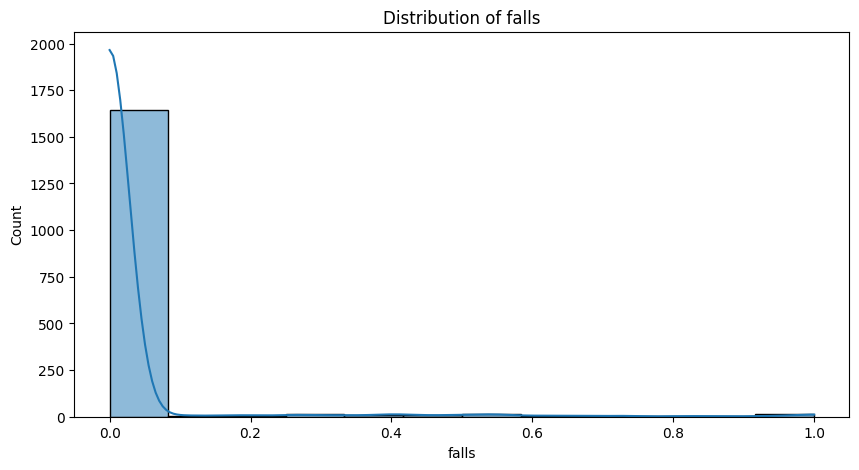

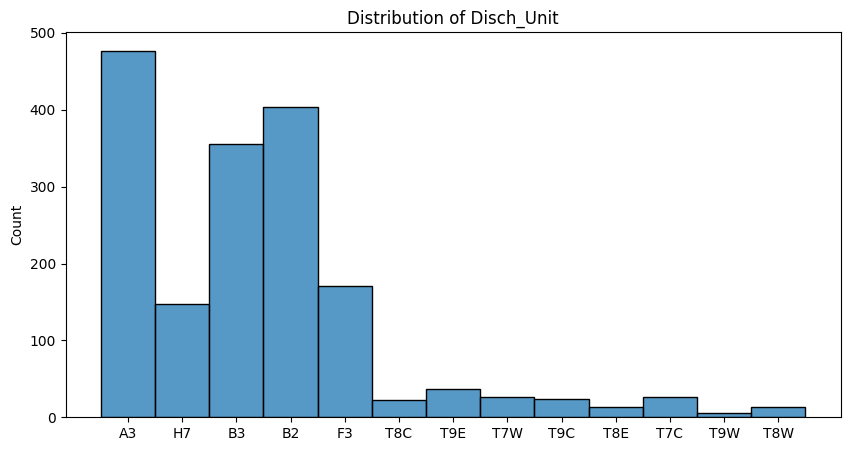

In [ ]:
import seaborn as sns
for feature in top_features:
    if feature in encoders:  # if the feature is categorical
        # Convert the encoded labels in X_test_res back to the original categories
        decoded_feature = encoders[feature].inverse_transform(X_test_res[feature])
        plt.figure(figsize=(10,5))
        sns.histplot(decoded_feature)
    else:
        plt.figure(figsize=(10,5))
        sns.histplot(X_test_res[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()


## Local Interpretations

This will create a force plot for the first instance in the test set. The output value is the prediction for that instance, and each feature value is shown as a force that either increases or decreases the prediction.

If you want to see how the features affect the prediction for another instance, you can simply change the indices in the last line of code. For example, shap_values[1,:] and X_test_res.iloc[1,:] will show you the SHAP values for the second instance.

In [ ]:
import shap

# First, create an explainer with your model and data
explainer = shap.TreeExplainer(xgb_model)

# Then calculate SHAP values
shap_values = explainer.shap_values(X_test_res)


In [ ]:
shap.initjs()

# Then use X_test_res_decoded in the shap.force_plot function
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test_res_decoded.iloc[10,:])


In [ ]:
import shap

# Create a new DataFrame to store the decoded features
X_test_res_decoded = X_test_res.copy()

# Apply the inverse transformation to each categorical feature
for feature in categorical_cols:
    X_test_res_decoded[feature] = encoders[feature].inverse_transform(X_test_res_decoded[feature])

# Then use X_test_res_decoded in the shap.force_plot function
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_res_decoded.iloc[0,:])


In [ ]:
# Get the encoder for 'Disch_Unit'
encoder = encoders['Disch_Unit']

# Retrieve the mapping
mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_))

# Convert the mapping to a DataFrame for nicer visualization
mapping_df = pd.DataFrame(list(mapping.items()), columns=['Encoded Label', 'Disch_Unit'])
print(mapping_df)


    Encoded Label Disch_Unit
0               0         A3
1               1         B2
2               2         B3
3               3         F3
4               4         H7
5               5        T7C
6               6        T7W
7               7        T8C
8               8        T8E
9               9        T8W
10             10        T9C
11             11        T9E
12             12        T9W


In [ ]:
# Get the encoder for 'Disch_Unit'
encoder = encoders['SERV_adm']

# Retrieve the mapping
mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_))

# Convert the mapping to a DataFrame for nicer visualization
mapping_df = pd.DataFrame(list(mapping.items()), columns=['Encoded Label', 'SERV_adm'])
print(mapping_df)

    Encoded Label SERV_adm
0               0      END
1               1      ENT
2               2      GIM
3               3       GU
4               4      HOS
5               5      HRT
6               6      ICU
7               7      NEP
8               8      OBS
9               9      ONC
10             10      ORT
11             11      PWC
12             12      RSP
13             13      SUR
14             14      THO


# EBM